In [1]:
import matplotlib.pyplot as plt
import torch  
import helper
import numpy as np

from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5), (0.5))
])

data = datasets.FashionMNIST('data/', download=True, train=False, transform=transform)
data_loader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)

In [3]:
class Network(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        super().__init__()
            
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        hidder_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in hidder_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        for linear in self.hidden_layers: # 输入层和隐藏层
            x = F.relu(linear(x))  # s函数采用 relu函数
            x = self.dropout(x) # 每次训练随机关闭部分节点
        
        x = self.output(x) # 输出层
            
        return F.log_softmax(x)  # log对数更好计算

In [11]:
model = Network(784, 10, [512, 256, 128, 64], drop_p=0.5)
criterion = nn.NLLLoss() # 对数交叉熵
optimizer = optim.Adam(model.parameters(), lr=0.001) # adam优化器 对参数优化 学习率为0.001 Adam相对于随机梯度下降速度更快

In [5]:
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
  )
  (output): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [12]:
def validation(model, testloader, criterion):
    test_loss = 0
    acc = 0
    
    for images, labels in test_loader:
        
        images.resize_(images.shape[0], 784)
        output = model.forward(images)
        test_loss += criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        acc += equality.type(torch.FloatTensor).mean()
    
    return test_loss, acc

In [21]:
epochs = 4
steps = 0
running_loss = 0
print_every = 40

for e in range(epochs):
    model.train()
    for images, labels in data_loader:
        steps += 1

        
        images.resize_(images.size()[0], 784) # 转换张量为输入层张量
        optimizer.zero_grad() # 重置反向传播梯度

        output = model.forward(images) # 训练特征
        loss = criterion(output, labels) # 计算交叉熵
        loss.backward() # 传递梯度
        optimizer.step()

        running_loss += loss.item()
    
        if steps % print_every == 0:
            model.eval()
            with torch.no_grad(): # 关闭所有梯度
                test_loss, acc = validation(model, test_loader, criterion)
            
            epoch = "Epoch: {}/{}...".format(e+1, epochs)
            train_loss = "Train loss: {:.3f}..".format(running_loss / print_every)
            test_loss = "Test loss: {:.3f}..".format(test_loss / len(test_loader))
            acc = "Acc: {:.3f}..".format(acc / len(test_loader))
            
            print(epoch, train_loss, test_loss, acc)
            running_loss = 0
            model.train()
            

/data/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/4... Train loss: 0.806.. Test loss: 0.627.. Acc: 0.757..
Epoch: 1/4... Train loss: 0.781.. Test loss: 0.602.. Acc: 0.768..
Epoch: 1/4... Train loss: 0.789.. Test loss: 0.621.. Acc: 0.770..
Epoch: 2/4... Train loss: 0.773.. Test loss: 0.629.. Acc: 0.752..
Epoch: 2/4... Train loss: 0.761.. Test loss: 0.573.. Acc: 0.778..
Epoch: 2/4... Train loss: 0.729.. Test loss: 0.590.. Acc: 0.771..
Epoch: 2/4... Train loss: 0.747.. Test loss: 0.571.. Acc: 0.781..
Epoch: 3/4... Train loss: 0.698.. Test loss: 0.603.. Acc: 0.763..
Epoch: 3/4... Train loss: 0.710.. Test loss: 0.552.. Acc: 0.784..
Epoch: 3/4... Train loss: 0.693.. Test loss: 0.581.. Acc: 0.769..
Epoch: 3/4... Train loss: 0.720.. Test loss: 0.542.. Acc: 0.788..
Epoch: 4/4... Train loss: 0.689.. Test loss: 0.544.. Acc: 0.789..
Epoch: 4/4... Train loss: 0.689.. Test loss: 0.538.. Acc: 0.791..
Epoch: 4/4... Train loss: 0.657.. Test loss: 0.517.. Acc: 0.795..
Epoch: 4/4... Train loss: 0.656.. Test loss: 0.520.. Acc: 0.796..


/data/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[8.1475e-15, 1.1119e-12, 7.2495e-14, 7.8034e-14, 2.1223e-11, 1.0803e-04,
         2.5612e-13, 2.8890e-03, 6.2057e-10, 9.9700e-01]])


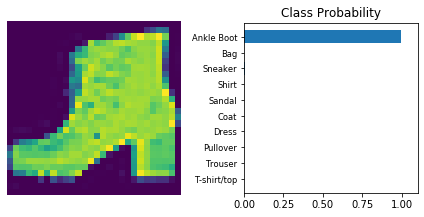

In [22]:
model.eval()
data = iter(test_loader)
images, labels = data.next()

img = images[0]
img = img.view(1, 784)

with torch.no_grad():
    output = model.forward(img)
    
ps = torch.exp(output)
print(ps)

helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')